### Imports

In [1]:
# -*- coding: utf-8 -*-
from __future__ import unicode_literals

import argparse
import cv2
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import scipy.misc
import glob

from IPython.display import display
from keras.callbacks import ModelCheckpoint
from keras.layers import Activation, Dense, Dropout, Flatten, Lambda, Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.models import Sequential
from keras.optimizers import Adam
from PIL import Image
from sklearn.model_selection import train_test_split

import utils # from utils.py

%matplotlib inline

Using TensorFlow backend.


### Constants

In [2]:
kSEED = 5
SIDE_STEERING_CONSTANT = 0.25
NUM_BINS = 23
NB_EPOCH = 15
LR = 1e-3

### Load data

In [3]:
# Location of the training data from Udacity.
file_name = 'driving_log.csv'
columns = [
    'Center Image',
    'Left Image',
    'Right Image',
    'Steering Angle',
    'Throttle',
    'Break',
    'Speed']

data_org = pd.read_csv(file_name, names=columns, header=0)
df = data_org.copy()
df[columns[:3]] = df[columns[:3]].astype(str)
df[columns[3:]] = df[columns[3:]].astype(float)

# Making new data
cnt = 1
for i in range(len(df)):
    if df['Steering Angle'][i]==0.0:
        df['Steering Angle'][i] = 0.1*np.random.uniform(-1,1)
    else:
        center_path = df['Center Image'][i]
        if '_trans' not in center_path:
            trans_angle = -1.0*df['Steering Angle'][i].copy()
            center_image = Image.open(center_path)
            center_image_trans = center_image.transpose(Image.FLIP_LEFT_RIGHT)
            name, ext = os.path.splitext(os.path.basename(center_path))
            save_path = os.path.join('/home/deepstation/AI_training/reverse/IMG','{}_trans.jpg'.format(name))
            center_image_trans.save(save_path)   
            end = cnt+len(df)
            df.loc[end] = [save_path,df['Right Image'][i],df['Left Image'][i],trans_angle,df['Throttle'][i],df['Break'][i],df['Speed'][i]]
            cnt +=1

df.to_csv('driving_log_m.csv')

file_name = 'driving_log_m.csv'
data = pd.read_csv(file_name, names=columns, header=0)
data[columns[:3]] = data[columns[:3]].astype(str)
data[columns[3:]] = data[columns[3:]].astype(float)
angles = data[columns[3]]

/home/deepstation/miniconda3/envs/NY/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


### What the data looks like

In [4]:
display(data.head())

,Center Image,Left Image,Right Image,Steering Angle,Throttle,Break,Speed
0,/home/deepstation/AI_training/reverse/IMG/cent...,/home/deepstation/AI_training/reverse/IMG/lef...,/home/deepstation/AI_training/reverse/IMG/rig...,-0.012678,0.0,0.0,0.000053
1,/home/deepstation/AI_training/reverse/IMG/cent...,/home/deepstation/AI_training/reverse/IMG/lef...,/home/deepstation/AI_training/reverse/IMG/rig...,0.090337,0.0,0.0,0.000051
2,/home/deepstation/AI_training/reverse/IMG/cent...,/home/deepstation/AI_training/reverse/IMG/lef...,/home/deepstation/AI_training/reverse/IMG/rig...,0.029751,0.0,0.0,0.000051
3,/home/deepstation/AI_training/reverse/IMG/cent...,/home/deepstation/AI_training/reverse/IMG/lef...,/home/deepstation/AI_training/reverse/IMG/rig...,0.039712,0.0,0.0,0.000053
4,/home/deepstation/AI_training/reverse/IMG/cent...,/home/deepstation/AI_training/reverse/IMG/lef...,/home/deepstation/AI_training/reverse/IMG/rig...,-0.056120,1.0,0.0,3.957871


### Data Statistics

It's always important to understand basic statistics about the data you will train on to avoid any bias. With pandas, it's super easy to analyze the data. Let's analyze the float values and also plot the steering angles to identify any potential biases.

In [5]:
display(data.describe())

,Steering Angle,Throttle,Break,Speed
count,1712.000000,1712.000000,1712.000000,1712.000000
mean,-0.001915,0.104589,0.002913,10.133679
std,0.439986,0.303596,0.053209,4.117641
min,-1.000000,0.000000,0.000000,0.000051
25%,-0.062631,0.000000,0.000000,7.356808
50%,-0.005735,0.000000,0.000000,9.479846
75%,0.060165,0.000000,0.000000,12.264882
max,1.000000,1.000000,1.000000,30.190290


Lets plot a histogram of the steering angles to get a better idea of how many examples we have for each angle.

"\n# miller images\nangle = data['Steering Angle'].copy()\ncnt = 1\nfor i in range(len(angle)):\n    if angle[i]!=0.0:\n        trans_angle = -1.0*angle[i]\n        angle[cnt+len(angle)] = trans_angle\n        cnt +=1\n    else:\n        angle[i] = 0.1*np.random.uniform(-1,1)\nprint(angle)\n\navg_samples_per_bin = len(angle)/num_bins\nhist, bins = np.histogram(angle, num_bins)\nwidth = 0.7 * (bins[1] - bins[0])\ncenter = (bins[:-1] + bins[1:]) * 0.5\nplt.bar(center, hist, align='center', width=width)\nplt.plot((np.min(angles), np.max(angles)), (avg_samples_per_bin, avg_samples_per_bin), 'k-')\n"

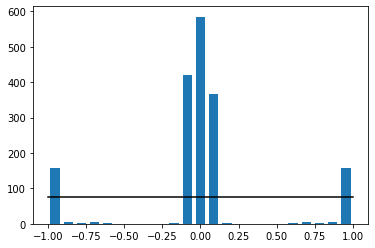

In [6]:
num_bins = 23
avg_samples_per_bin = len(data['Steering Angle'])/num_bins
hist, bins = np.histogram(data['Steering Angle'], num_bins)
width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) * 0.5
plt.bar(center, hist, align='center', width=width)
plt.plot((np.min(angles), np.max(angles)), (avg_samples_per_bin, avg_samples_per_bin), 'k-')
"""
# miller images
angle = data['Steering Angle'].copy()
cnt = 1
for i in range(len(angle)):
    if angle[i]!=0.0:
        trans_angle = -1.0*angle[i]
        angle[cnt+len(angle)] = trans_angle
        cnt +=1
    else:
        angle[i] = 0.1*np.random.uniform(-1,1)
print(angle)

avg_samples_per_bin = len(angle)/num_bins
hist, bins = np.histogram(angle, num_bins)
width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) * 0.5
plt.bar(center, hist, align='center', width=width)
plt.plot((np.min(angles), np.max(angles)), (avg_samples_per_bin, avg_samples_per_bin), 'k-')
"""

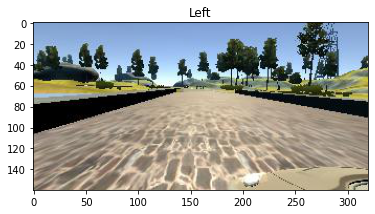

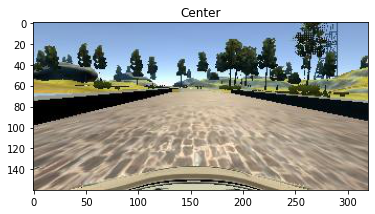

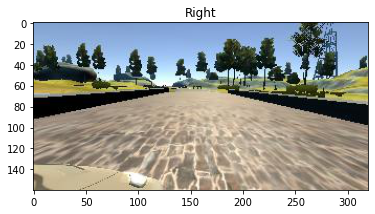

In [7]:
left_image = Image.open('images/left.jpg')
_ = plt.imshow(left_image)
plt.title('Left')
plt.show()

center_image = Image.open('images/center.jpg')
_ = plt.imshow(center_image)
plt.title('Center')
plt.show()

right_image = Image.open('images/right.jpg')
_ = plt.imshow(right_image)
plt.title('Right')
plt.show()

In [8]:
images = data[columns[:3]]
angles = data[columns[3]]

X_train, X_val, y_train, y_val = train_test_split(images, angles, test_size=0.15, random_state=kSEED)

In [9]:
def batch_generator(images, angles, augment_data=True, batch_size=64):
    """
    Keras Batch Generator to create a generator of training examples for model.

    :param images: Training image data.
    :param angles: Angle data for images.
    :param batch_size: Batch size of each training run.
    :param augment_data: If the data should be augmented.

    :return: A batch generator.
    """
    batch_images = []
    batch_angles = []
    sample_count = 0

    while True:
        # Shuffle indices to minimize overfitting.
        for i in np.random.permutation(images.shape[0]):

            # Image (1) -> Center image and steering angle.
            center_path = images.iloc[i]['Center Image']
            left_path = images.iloc[i]['Left Image']
            right_path = images.iloc[i]['Right Image']
            angle = float(angles.iloc[i])

            center_image = utils.load_image(center_path)
         #   center_image = augment_brightness(center_image)
            batch_images.append(center_image)
            batch_angles.append(angle)
            
            sample_count += 1
            
            if ((sample_count % batch_size == 0) or (sample_count % len(images) == 0)):
                yield np.array(batch_images), np.array(batch_angles)
                # Reset batch/
                batch_images = []
                batch_angles = []

In [10]:
model = Sequential()
# Lambda layer normalizes pixel values between 0 and 1
model.add(Lambda(lambda x: x / 127.5 - 1.0, input_shape=(66, 200, 3)))
# Convolutional layer (1)
model.add(Conv2D(24, (5,5), padding='same', activation='relu', strides=(2,2)))
model.add(MaxPooling2D(pool_size=(2,2), strides=(1, 1)))
# Convolutional layer (2)
model.add(Conv2D(36, (5,5), padding='same', activation='relu', strides=(2,2)))
model.add(MaxPooling2D(pool_size=(2,2), strides=(1, 1)))
# Convolutional layer (3)
model.add(Conv2D(48, (5,5), padding='same', activation='relu', strides=(2,2)))
model.add(MaxPooling2D(pool_size=(2,2), strides=(1, 1)))
# Convolutional layer (4)
model.add(Conv2D(64, (3,3), padding='same', activation='relu', strides=(1,1)))
model.add(MaxPooling2D(pool_size=(2,2), strides=(1, 1)))
# Convolutional layer (5)
model.add(Conv2D(64, (3,3), padding='same', activation='relu', strides=(1,1)))
model.add(MaxPooling2D(pool_size=(2,2), strides=(1, 1)))
# Flatten Layer
model.add(Flatten())
# Dense Layer (1)
model.add(Dense(1164, activation='relu'))
# Dense layer (2)
model.add(Dense(100, activation='relu'))
# Dense layer (3)
model.add(Dense(50, activation='relu'))
# Dense layer (4)
model.add(Dense(10, activation='relu'))
# Dense layer (5)
model.add(Dense(1))
# Compile model
model.compile(optimizer=Adam(lr=LR, decay=LR / NB_EPOCH), loss='mse')

#### Model Summary

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, 66, 200, 3)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 33, 100, 24)       1824      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 99, 24)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 50, 36)        21636     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 49, 36)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 25, 48)         43248     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 24, 48)         0

In [12]:
generator_train = batch_generator(X_train, y_train, augment_data=True)
generator_val = batch_generator(X_val, y_val, augment_data=False)

Fit the model to the data we created from our batch generator. Here steps per epoch is the number of examples we have which is 6 times the number of training examples. We get the number six from the original 3 left, right, center examples + the three augmented examples (flipped, tinted, jittered). For the steps in validation however since we only use center images its simply how many examples we have. We train our model for 15 epochs.

In [13]:
model.fit_generator(
        generator_train,
        steps_per_epoch=6 * len(X_train),
        epochs=NB_EPOCH,
        validation_data=generator_val,
        validation_steps=len(X_val),
        verbose=1)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/15
8730/8730 [==============================] - 1830s 210ms/step - loss: 0.0183 - val_loss: 0.1367
Epoch 2/15
8730/8730 [==============================] - 1833s 210ms/step - loss: 9.5040e-04 - val_loss: 0.1321
Epoch 3/15
8730/8730 [==============================] - 1831s 210ms/step - loss: 7.6490e-04 - val_loss: 0.1217
Epoch 4/15
8730/8730 [==============================] - 1831s 210ms/step - loss: 2.4668e-04 - val_loss: 0.1213
Epoch 5/15
8730/8730 [==============================] - 1832s 210ms/step - loss: 1.3664e-04 - val_loss: 0.1270
Epoch 6/15
8730/8730 [==============================] - 1832s 210ms/step - loss: 1.1303e-04 - val_loss: 0.1258
Epoch 7/15
8730/8730 [==============================] - 1832s 210ms/step - loss: 4.6311e-05 - val_loss: 0.1349
Epoch 8/15
8730/8730 [==============================] - 1831s 210ms/step - loss: 4.4014e-05 - val_loss: 0.1342
Epoch 9/15
8730/8730 [==================

We can save model for later use.

In [14]:
model.save_weights('model.h5', True)
with open('model.json', 'w') as outfile:
    json.dump(model.to_json(), outfile)